In [89]:
import numpy as np
import sys
from tsfracdiff import FractionalDifferentiator
sys.path.append('..')
from lib.download import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import optim
from TimesNET import Model

class cfg:
    def __init__(self):
        self.seq_len = 8 #longueur de la sequence 24*30*6
        self.pred_len = 1 #nombre detapes a pred, essayer 24
        self.label_len = self.pred_len
        self.d_model = 16 #dimension des deep features
        self.d_ff = 16 #dimension de skernels de l(inception)
        self.enc_in = len(data_aligned.columns) #nombre de features
        self.c_out = 1 # nombre de sorties (peut potentiellement predire plusieurs variables a la suite)
        self.e_layers = 2 #nombre de timesBlock a potentiellement augmenter avec le nombre de features
        self.embed = 'timeF' #type d'embed par défaut (sorte de time2vec series temporelles)
        self.freq = 'h' #frequence des données
        self.dropout = 0.1 #dropout pr l'embedding
        self.top_k = 2 #ombre de frequences a prendre en compte
        self.num_kernels = 3 #333333 #comme dans le modele inceptionv1
        self.learning_rate = 0.001
        self.batch_size = 16
        self.features = ['close','open']
        self.target = 'target'
        self.checkpoints = 'test'
        self.patience = 3
        self.loss = 'MSE'
        self.train_epochs = 20 #12
        self.lradj = 'type2'
        self.fracdiff = 'on'
        self.minus_n_features = 150

In [104]:
from sklearn.preprocessing import StandardScaler
from timefeatures import time_features
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class CryptoLoader(Dataset):
    def __init__(self, df, flag='predict', features=['close','open'], target='target', timeenc=0, freq='h', minus_n_features = 150):
        self.df = df.reset_index() # pour mettre le timestamp dans une nouvelle column          
        self.target = target
        self.timeenc = timeenc
        self.config = cfg()
        self.freq = freq
        assert flag in ['train', 'test', 'val', 'predict']
        type_map = {'train': 0, 'val': 1, 'test': 2, 'predict': 3}
        self.set_type = type_map[flag]
        self.__read_data__()
        
    def __read_data__(self):
        df_raw = self.df.copy()
        cols = list(df_raw.columns)
        cols.remove(self.target)
        cols.remove('timestamp')
        df_raw = df_raw[['timestamp'] + cols + [self.target]]
        
        border1 = 0
        border2 = len(df_raw)
            
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]
        dataa = scalleerr.transform(df_data.values)
        
        #encodage des données temporelles
        df_stamp = df_raw[['timestamp']][border1:border2]
        df_stamp['timestamp'] = pd.to_datetime(df_stamp.timestamp)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.timestamp.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.timestamp.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.timestamp.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.timestamp.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['timestamp'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['timestamp'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)
        self.data_x = dataa[border1:border2]
        self.data_y = dataa[border1:border2]
        self.data_stamp = data_stamp
        
        
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.config.seq_len
        r_begin = s_end - self.config.label_len
        r_end = r_begin + self.config.label_len + self.config.pred_len
        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.config.seq_len - self.config.pred_len + 1

def data_provider(df, args, flag):
    timeenc = 0 if args.embed != 'timeF' else 1
    shuffle_flag = False
    drop_last = False
    batch_size = 1  # bsz=1 for evaluation
    data_set = CryptoLoader(
        df=df,
        flag=flag,
        features=args.features,
        target=args.target,
        timeenc=timeenc,
    )

    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        drop_last=drop_last
    )
    return data_set, data_loader


def predict_new_data(data, model, ticker):
    args = cfg()
    data_set, data_loader = data_provider(df=data, args=args, flag='predict')
    preds = []
    trues = []
    folder_path = './outofsample/' + ticker + '/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in tqdm(enumerate(data_loader)):
            # Move data to device
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            # Decoder input
            dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(device)

            # Encoder - decoder
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

            f_dim = -1
            outputs = outputs[:, -args.pred_len:, f_dim:]
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)
            outputs = outputs.detach().cpu().numpy()
            batch_y = batch_y.detach().cpu().numpy()

            pred = outputs
            true = batch_y
            preds.append(pred)
            trues.append(true)
    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    trues = np.array(trues)
    trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        
    return preds, trues

exp_name = '/LINKUSDT_ohlc_8_top2_samelr'
model_path = 'test' +exp_name +'/checkpoint.pth'
device = torch.device('cuda')

#01 february 2023
new_data = download_symbol_data('LINKUSDT', start = "01 may 2020")
new_data = new_data[new_data.index < '2023-05-01']
new_data_target_aligned = new_data[['close']].copy().shift(-1).iloc[:-1]
new_data = new_data.iloc[1:-1,:4]
new_data["target"] = new_data_target_aligned
new_data = new_data.astype(float)



data = get_data_features('LINKUSDT').dropna()
data = data.loc[:, data.nunique() != 1]

#close j+1 est la target
target_aligned = data[['close']].copy().shift(-1).iloc[:-1]
data_aligned = data.iloc[:-1,:4]
data_aligned["target"] = target_aligned

target_train = pd.DataFrame(data_aligned.iloc[:int(len(data_aligned) * 0.7),-1].copy())
data_train = pd.DataFrame(data_aligned.iloc[:int(len(data_aligned) * 0.7),:].copy())

target_scaler = StandardScaler()
target_scaler = target_scaler.fit(target_train)

scalleerr = StandardScaler()
scalleerr = scalleerr.fit(data_train)

model_state = torch.load(model_path, map_location=device)
model = Model(cfg()).to(device)
model.load_state_dict(model_state)
model.eval()
;

''

In [105]:
preds, true = predict_new_data(new_data, model, 'LINKUSDT')

26247it [02:52, 152.42it/s]


<Axes: xlabel='timestamp'>

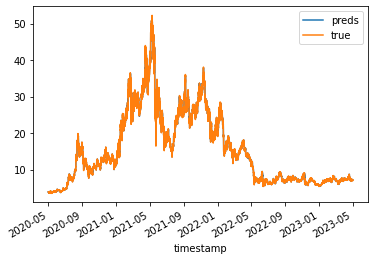

In [107]:
rescaled_data = pd.DataFrame(target_scaler.inverse_transform(true.T[0][0].reshape(-1,1)), columns=['true'])
rescaled_data['preds'] = pd.DataFrame(target_scaler.inverse_transform(preds.T[0][0].reshape(-1,1)))
rescaled_data['true_return'] = rescaled_data['true'].pct_change()
rescaled_data['predicted_return'] = rescaled_data['preds'] / rescaled_data['true'].shift(1) - 1
rescaled_data.index = new_data_target_aligned.iloc[-len(preds):].index
rescaled_data['predicted_return_to_last_pred'] = rescaled_data['preds'].pct_change()
rescaled_data = rescaled_data[1:]

rescaled_data[['preds','true']].plot()

<Axes: xlabel='timestamp'>

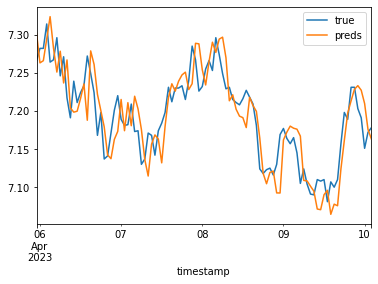

In [108]:
rescaled_data.iloc[-600:-500,:-3].plot()

In [ ]:
tester d'autres algos backtest, multi strategy, stoploss, take profit
ameliorer algo aussi

In [109]:
class SimpleBacktester:
    def __init__(self, initial_cash, data, buy_threshold, sell_threshold, fee=0.001):
        self.initial_cash = initial_cash
        self.data = data
        self.cash = initial_cash
        self.asset_value = 0
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold
        self.fee = fee

    def run(self):
        portfolio = pd.DataFrame(index=self.data.index)
        portfolio['cash'] = 0
        portfolio['asset_value'] = 0
        portfolio['total_value'] = 0
        portfolio['returns'] = 0
        trade_counter = 0
        positive_trades = 0
        total_fees = 0

        for i in range(len(self.data)):
            if self.data['risk_adj_predicted_return'].iloc[i] > self.buy_threshold and self.asset_value == 0:
                # Buy as much as possible, considering fee
                amount_to_invest = self.cash * (1 - self.fee)
                fee_paid = self.cash - amount_to_invest
                total_fees += fee_paid
                self.asset_value = amount_to_invest / self.data['true'].iloc[i]
                self.cash -= amount_to_invest
                trade_counter += 1

            elif self.data['risk_adj_predicted_return'].iloc[i] < self.sell_threshold and self.asset_value > 0:
                # Sell all
                asset_sale_value = self.asset_value * self.data['true'].iloc[i]
                fee_paid = asset_sale_value * self.fee
                total_fees += fee_paid
                asset_sale_value -= fee_paid
                if asset_sale_value > self.asset_value:
                    positive_trades += 1
                self.cash += asset_sale_value
                self.asset_value = 0
                trade_counter += 1

            portfolio['cash'].iloc[i] = self.cash
            portfolio['asset_value'].iloc[i] = self.asset_value * self.data['true'].iloc[i]
            portfolio['total_value'].iloc[i] = portfolio['cash'].iloc[i] + portfolio['asset_value'].iloc[i]
            if i > 0:
                portfolio['returns'].iloc[i] = (portfolio['total_value'].iloc[i] - portfolio['total_value'].iloc[i-1]) / portfolio['total_value'].iloc[i-1]

        # calculate performance metrics
        portfolio['drawdown'] = portfolio['total_value'] / portfolio['total_value'].cummax() - 1.0
        average_drawdown = portfolio['drawdown'].mean()
        sharpe_ratio = portfolio['returns'].mean() * np.sqrt(8766) / portfolio['returns'].std()
        sortino_ratio = portfolio['returns'].mean() * np.sqrt(8766) / portfolio['returns'][portfolio['returns'] < 0].std()

        return portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees
    
def downside_deviation(series):
    # series below 0
    downside = series[series < 0]
    return np.sqrt((downside**2).mean())

# Calculate the downside deviation for a rolling window
downside_dev = rescaled_data['true_return'].rolling(window=12).apply(downside_deviation, raw=True)

rescaled_data['risk_adj_predicted_return'] = rescaled_data['predicted_return'] / downside_dev

In [ ]:
psg pas mal pour ameliorer algo (detection de baisse trop importante?)

Average Drawdown:  -0.23035398373328614
Sharpe Ratio:  0.8818673992875504
Sortino Ratio:  0.4367137123602454
trade_counter:  1505
total fees:  4667.381451645613
Total value: 26991.785547686955


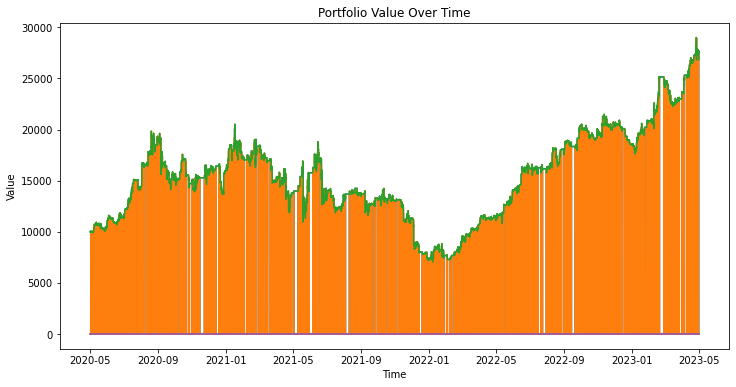

In [110]:
#LINK
b,s =1.15, -.4
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.40833987544013384
Sharpe Ratio:  0.5302860408419866
Sortino Ratio:  0.3006645950309185
trade_counter:  1768
total fees:  5548.406807802493
Total value: 15093.65154860278


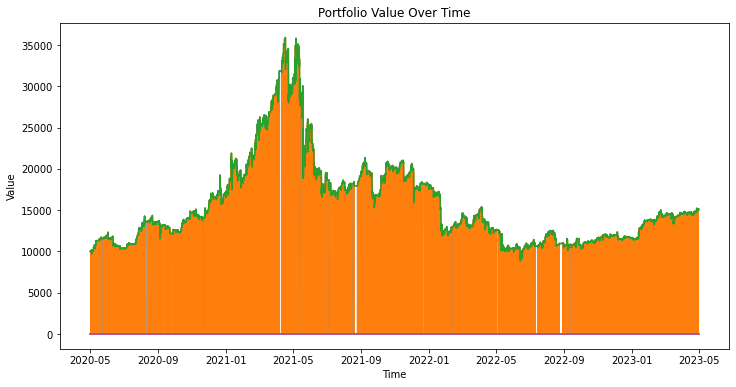

In [103]:
#BCHUSDT
b,s =1.2,-.6
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.1319037474488071
Sharpe Ratio:  0.687214017035946
Sortino Ratio:  0.4585866697076245
trade_counter:  728
total fees:  1394.0360904968436
Total value: 12327.116779086426


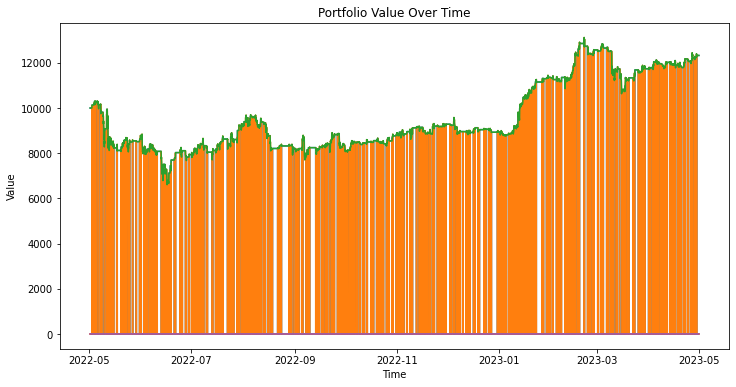

In [96]:
#BCHUSDT
b,s =1.2,-.6
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:
gros impact de la premiere donnée que je vois

Average Drawdown:  -0.06611614460712578
Sharpe Ratio:  1.6416357262348071
Sortino Ratio:  1.145168300395858
trade_counter:  1814
total fees:  6353.823080392792
Total value: 18797.470077585094


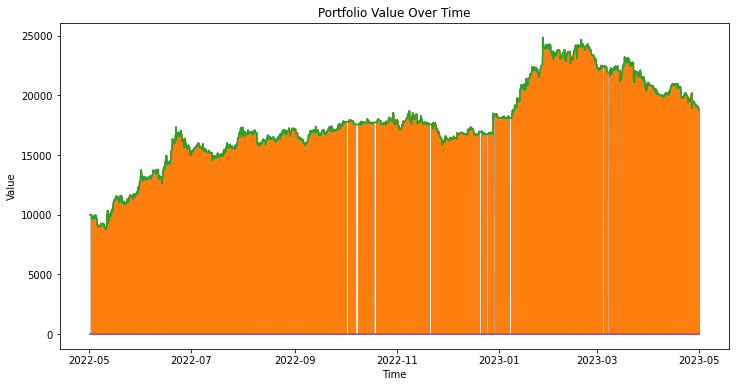

In [88]:
#HOTUSDT
b,s =.4, -.1
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.07503527087889243
Sharpe Ratio:  2.3176262777794956
Sortino Ratio:  2.0284093521329583
trade_counter:  2474
total fees:  11074.499456977956
Total value: 32537.359051283533


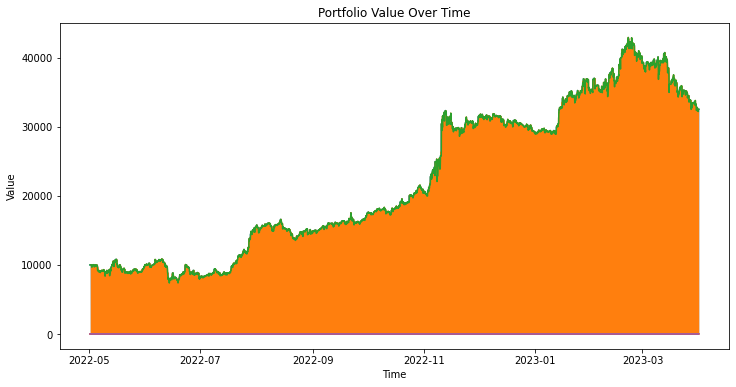

In [80]:
#MATIC
b,s =0.5, 0.1
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.061951153573575696
Sharpe Ratio:  2.4210550432746256
Sortino Ratio:  1.662964164500888
trade_counter:  1476
total fees:  4921.7777278163785
Total value: 20516.301542837075


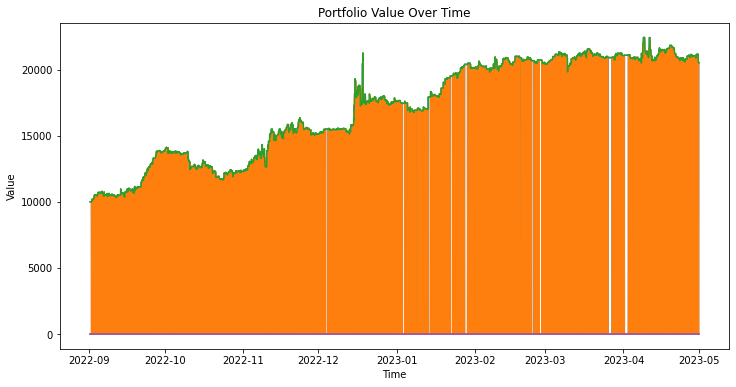

In [33]:
#PSG
b,s =0.45, .15
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.26512745207238025
Sharpe Ratio:  0.8609409182599429
Sortino Ratio:  0.9416753935719213
trade_counter:  2664
total fees:  5160.887190401507
Total value: 14056.269077710678


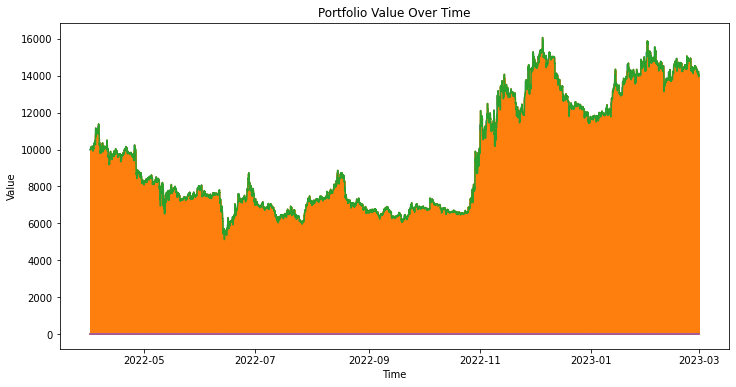

In [16]:
#doge
b,s =0,-.1
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.03592980992118744
Sharpe Ratio:  2.7420335190457465
Sortino Ratio:  1.6932127213751103
trade_counter:  481
total fees:  1572.3675641082564
Total value: 22581.81935737348


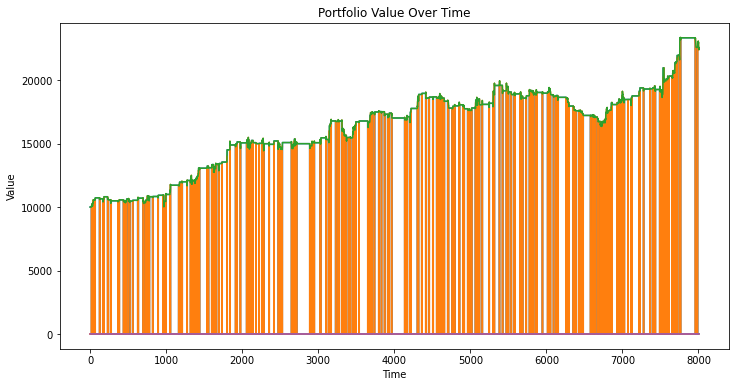

In [22]:
#LINK
b,s =1.15, -.4
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.03381138109730526
Sharpe Ratio:  1.117625997625652
Sortino Ratio:  0.6543308335614233
trade_counter:  202
total fees:  414.57311013779537
Total value: 11144.725237096709


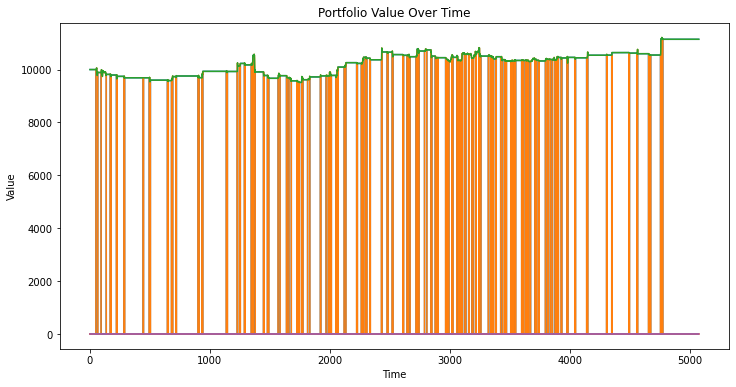

In [59]:
#btcusdt
b,s = 1.6,-0.3
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.15483388849375562
Sharpe Ratio:  1.7770652520217407
Sortino Ratio:  1.9968653787647848
trade_counter:  1682
total fees:  4995.527140515135
Total value: 19401.86991335244


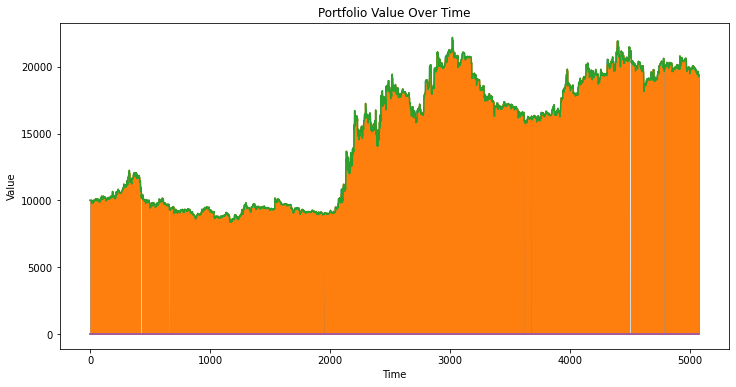

In [50]:
#dogfe pas mal avec ca
b,s =0,-.1
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:

b,s =0,-.1
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.0774216634931319
Sharpe Ratio:  0.9082580340274073
Sortino Ratio:  0.5340819541650131
trade_counter:  247
total fees:  582.4067046476983
Total value: 11010.79161811319


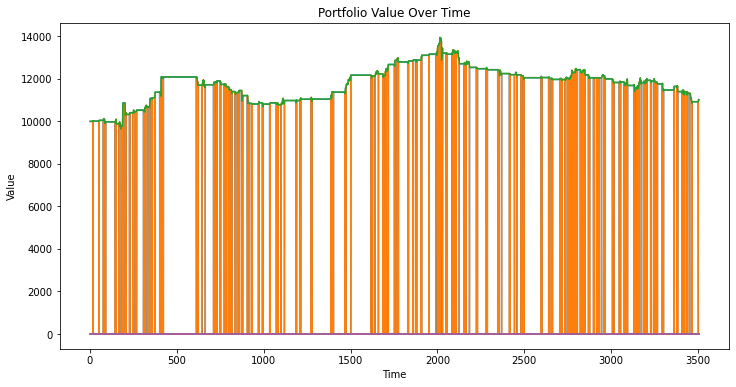

In [70]:
b,s =1.15, -.4
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.05037137140863407
Sharpe Ratio:  1.6482607099339226
Sortino Ratio:  0.9317583837442418
trade_counter:  326
total fees:  824.988531871508
Total value: 12311.344865953399


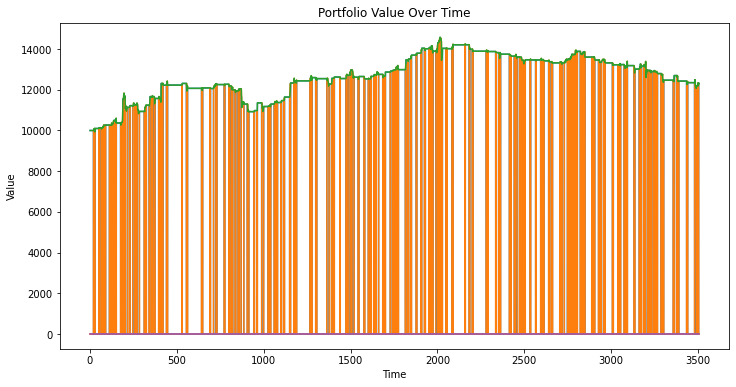

In [38]:
b,s =1.15, -.4
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Average Drawdown:  -0.04834073382127248
Sharpe Ratio:  2.3126714410390234
Sortino Ratio:  1.580389406757115
trade_counter:  356
total fees:  934.4396178059267
Total value: 13465.537692548702


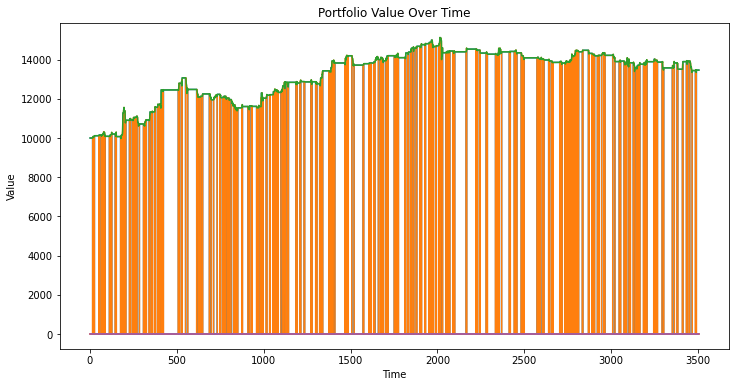

In [18]:
b,s =1.15, -.4
backtester = SimpleBacktester(10000, rescaled_data, b, s, 0.0002)

portfolio, average_drawdown, sharpe_ratio, sortino_ratio, trade_counter, total_fees= backtester.run()

import matplotlib.pyplot as plt
print("Average Drawdown: ", average_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)
print("Sortino Ratio: ", sortino_ratio)
print("trade_counter: ",trade_counter)
print("total fees: ", total_fees)
print("Total value: " + str(portfolio['total_value'].iloc[-2]))
plt.figure(figsize=(12,6))
plt.plot(portfolio)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:
Si MAPE (a la difference du mse qui prend pas en compte la baisse de la valeur dans le temps) augmente dans le temps (out of sample) => overfitting

voir si mauvaises perf sont liées a des mape faibles